# Анализ датасета с данными о мошеннических операциях с банковскими картами и построение модели прогноза.

Исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# загрузим датасет
data = pd.read_csv("/content/credit_card_fraud_dataset.csv")
data.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


In [2]:
# Проверим наличие пропущенных значений
print("Количество пропущенных значений:")
print(data.isnull().sum())

Количество пропущенных значений:
TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64


In [5]:
# Проверим и удалим дубликаты, если они есть
print(f"Дубликаты: {data.duplicated(keep=False).sum()}")

Дубликаты: 0


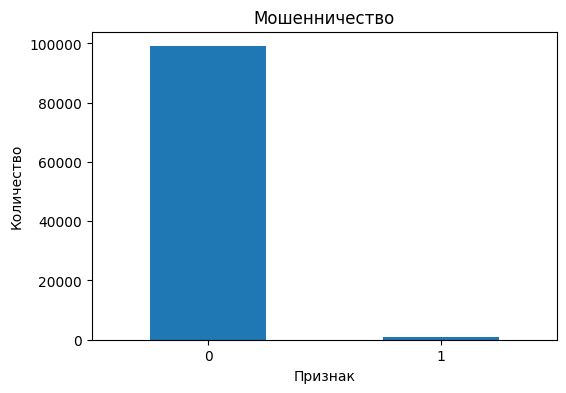

In [24]:
fraud_count = data['IsFraud'].value_counts()

# Строим график распределения признака о мошенничестве
plt.figure(figsize=(6, 4))
fraud_count.plot(kind='bar')
plt.title('Мошенничество')
plt.xlabel('Признак')
plt.ylabel('Количество')
plt.xticks([0, 1], ['0', '1'], rotation=0)
plt.show()

Присутствует дисбаланс классов. Разобъем колонку TransactionDate на колонки с конкретным днем месяца (TransactionDate), днем недели (DayOfWeek) и часом (TransactionTime).

In [9]:
data['TransactionTime'] = pd.to_datetime(data['TransactionDate']).dt.hour
data['TransactionMonth'] = pd.to_datetime(data['TransactionDate']).dt.month
data['DayOfWeek'] = pd.to_datetime(data['TransactionDate']).dt.dayofweek
data['TransactionDate'] = pd.to_datetime(data['TransactionDate']).dt.day
data.drop(columns=['TransactionID'], axis=1, inplace=True)

data.head()

,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud,TransactionTime,TransactionMonth,DayOfWeek
0,3,4189.27,688,refund,San Antonio,0,14,4,2
1,19,2659.71,109,refund,Dallas,0,13,3,1
2,8,784.00,394,purchase,New York,0,10,1,0
3,13,3514.40,944,purchase,Philadelphia,0,23,4,5
4,12,369.07,475,purchase,Phoenix,0,18,7,4


Посмотрим на зависимость количества мошеннических операций от местоположения, времени транзакций, месяца и дня недели.

Text(0.5, 1.0, 'Количество всех операций относительно местоположения')

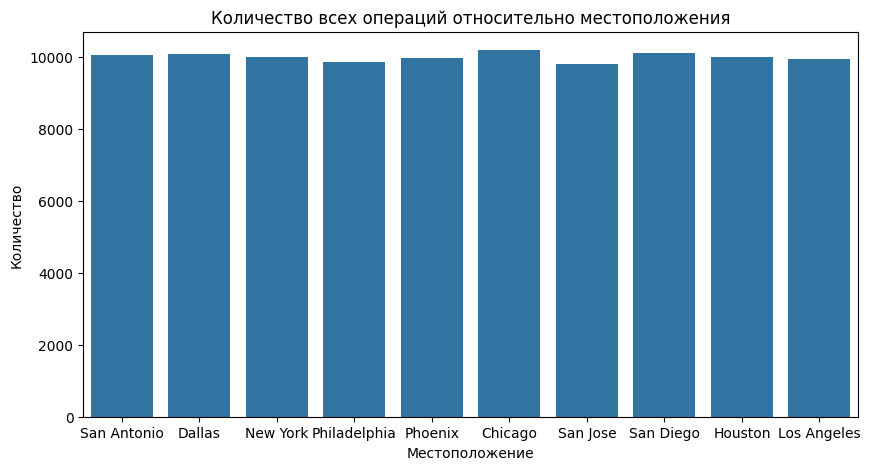

In [14]:
df_fraud = data[data['IsFraud'] == 1]

plt.figure(figsize=(10,5))

sns.countplot(data=data, x='Location')

plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.title('Количество всех операций относительно местоположения')

Text(0.5, 1.0, 'Количество мошеннических операций относительно местоположения')

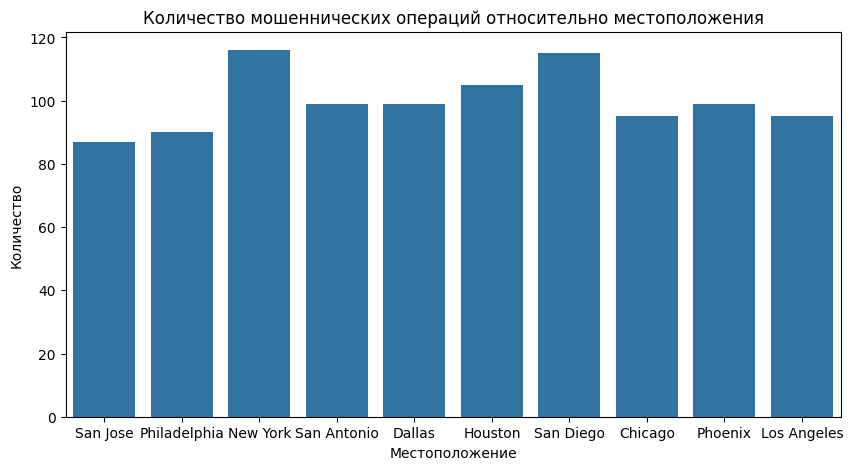

In [13]:
plt.figure(figsize=(10,5))

sns.countplot(data=df_fraud, x='Location')
plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.title('Количество мошеннических операций относительно местоположения')


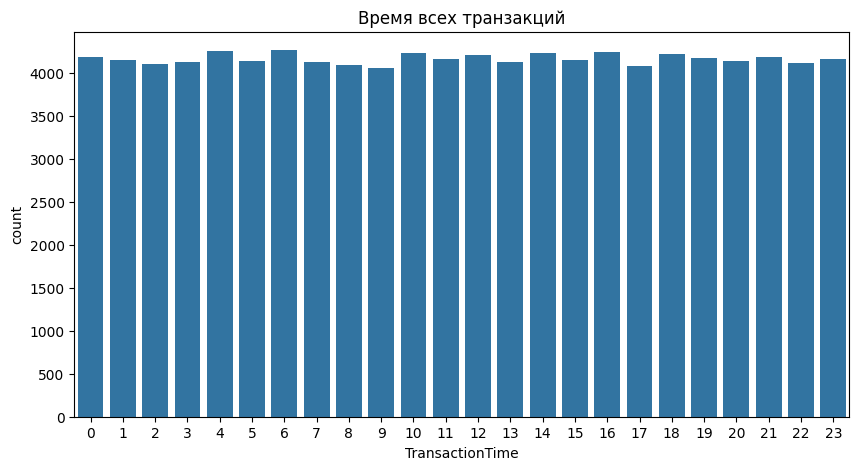

In [16]:
plt.figure(figsize=(10,5))

sns.countplot(data=data, x='TransactionTime')
plt.title('Время всех транзакций')
plt.show()

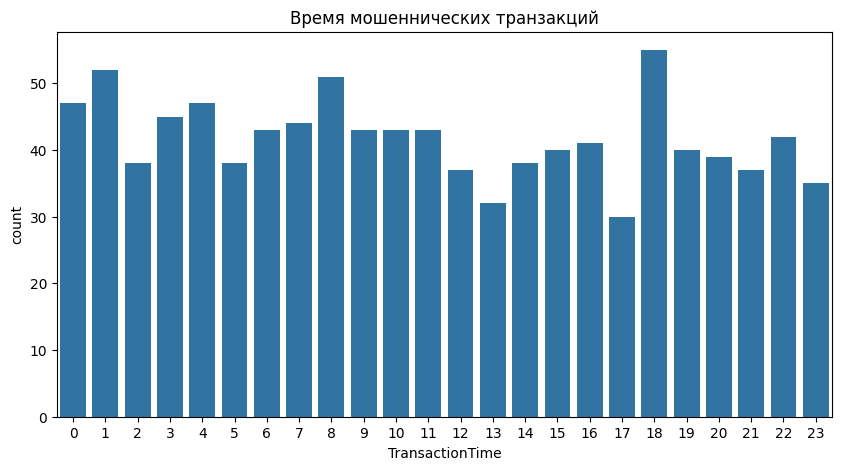

In [17]:
plt.figure(figsize=(10,5))

sns.countplot(data=df_fraud, x='TransactionTime')
plt.title('Время мошеннических транзакций')
plt.show()

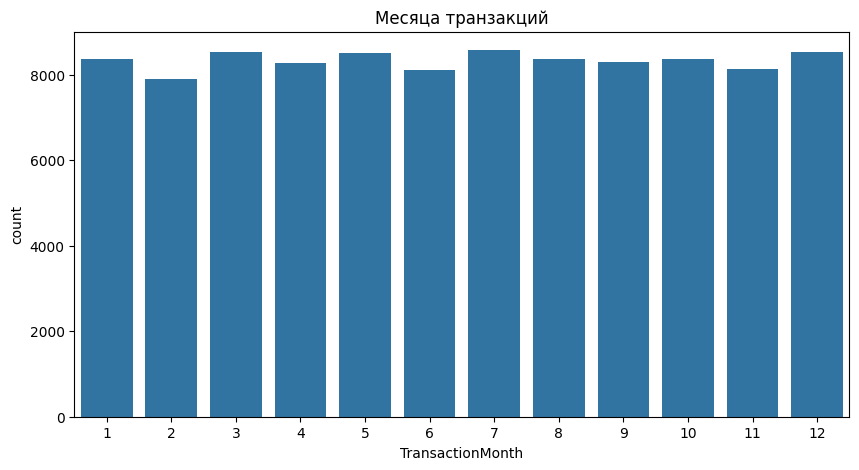

In [18]:
plt.figure(figsize=(10,5))

sns.countplot(data=data, x='TransactionMonth')
plt.title('Месяца транзакций')
plt.show()

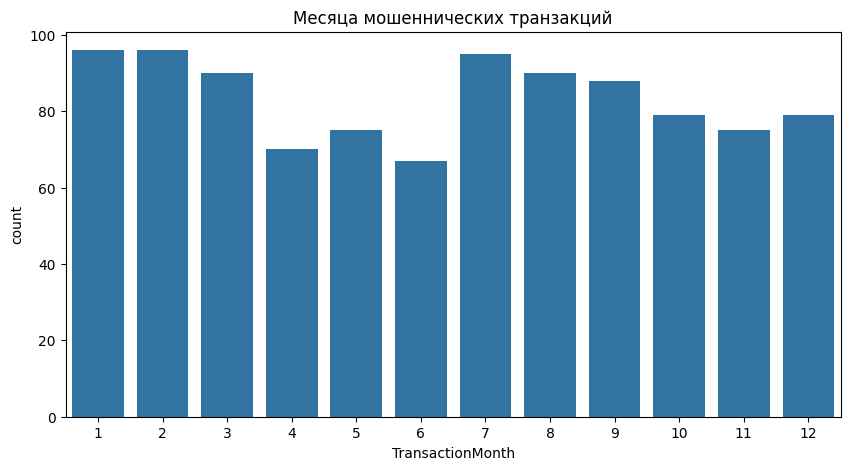

In [19]:
plt.figure(figsize=(10,5))

sns.countplot(data=df_fraud, x='TransactionMonth')
plt.title('Месяца мошеннических транзакций')
plt.show()

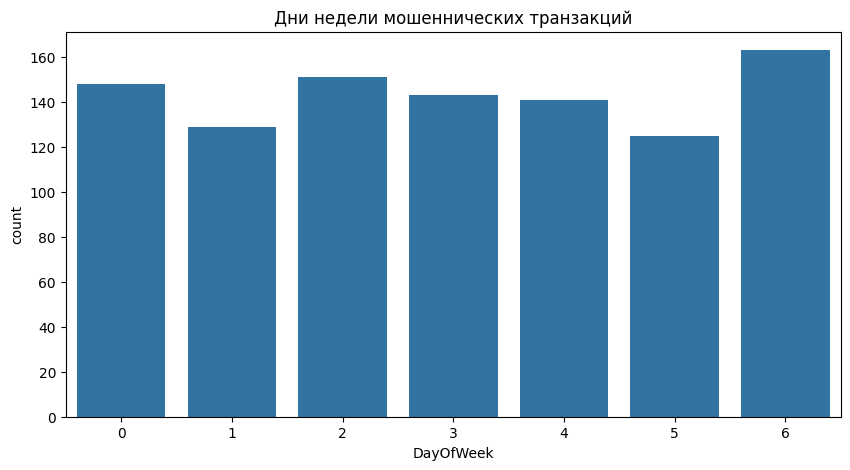

In [21]:
plt.figure(figsize=(10,5))

sns.countplot(data=df_fraud, x='DayOfWeek')
plt.title('Дни недели мошеннических транзакций')
plt.show()

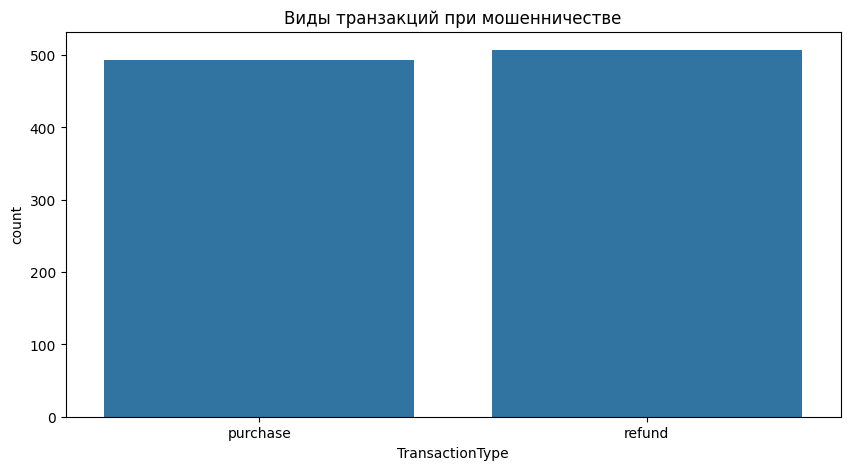

In [23]:
plt.figure(figsize=(10,5))

sns.countplot(data=df_fraud, x='TransactionType')
plt.title('Виды транзакций при мошенничестве')
plt.show()

Обучение модели RandomForestClassifier и корректировка дисбаланса классов.

In [28]:
df = pd.get_dummies(data, columns=['Location', 'TransactionType'])
df.head()

,TransactionDate,Amount,MerchantID,IsFraud,TransactionTime,TransactionMonth,DayOfWeek,Location_0.0,Location_1.0,Location_2.0,Location_3.0,Location_4.0,Location_5.0,Location_6.0,Location_7.0,Location_8.0,Location_9.0,TransactionType_0.0,TransactionType_1.0
0,3,4189.27,688,0,14,4,2,False,False,False,False,False,False,False,True,False,False,False,True
1,19,2659.71,109,0,13,3,1,False,True,False,False,False,False,False,False,False,False,False,True
2,8,784.00,394,0,10,1,0,False,False,False,False,True,False,False,False,False,False,True,False
3,13,3514.40,944,0,23,4,5,False,False,False,False,False,True,False,False,False,False,True,False
4,12,369.07,475,0,18,7,4,False,False,False,False,False,False,True,False,False,False,True,False


In [29]:
X = df.drop('IsFraud', axis=1)
y = df['IsFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

# Получение весов классов
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Создание модели с взвешиванием классов
model_1 = RandomForestClassifier(class_weight=dict(enumerate(class_weights)))

model_1.fit(X_train, y_train)

predict_1 = model_1.predict(X_test)

print('Accuracy Random Foresct Classifier: ', accuracy_score(y_test, predict_1))
print(classification_report(y_test, predict_1))

Accuracy Random Foresct Classifier:  0.9895333333333334
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29686
           1       0.00      0.00      0.00       314

    accuracy                           0.99     30000
   macro avg       0.49      0.50      0.50     30000
weighted avg       0.98      0.99      0.98     30000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

pipeline = make_pipeline(
    #RandomOverSampler(),  #  применяем оверсэмплинг
    SMOTE()                # или  SMOTE
)

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

model_2 = RandomForestClassifier(n_estimators=100, random_state=52)
model_2.fit(X_resampled, y_resampled)

predict_2 = model_2.predict(X_test)

print('Accuracy Random Foresct Classifier: ', accuracy_score(y_test, predict_2))
print(classification_report(y_test, predict_2))

Accuracy Random Foresct Classifier:  0.9893666666666666
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29686
           1       0.00      0.00      0.00       314

    accuracy                           0.99     30000
   macro avg       0.49      0.50      0.50     30000
weighted avg       0.98      0.99      0.98     30000

